In [41]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import re
import json
import math
import seaborn as sns
import matplotlib.pyplot as plt

winsorise = False ### CHANGE IF NECESSARY

symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)
symbols_list.remove('scbtc') # bad

returns_folder_name = "full_returns"

figures_folder_name = "figures"
figures_subfolder_name = "exploration"
if winsorise:
    returns_folder_name = "full_returns_winsorised"
    figures_subsubfolder_name = "winsorised"
else:
    figures_subsubfolder_name = "raw"

figures_path_base = os.path.join(
    os.getcwd(),
    figures_folder_name,
    figures_subfolder_name,
    figures_subsubfolder_name,
)
    
ts_list = []
for symbol in symbols_list:
    save_file_name = symbol + '.csv.gz'
    save_path = os.path.join(os.getcwd(), returns_folder_name, save_file_name)
    df = pd.read_csv(save_path, compression='gzip')
    ts_list.append(df['log_return'].rename(symbol))
all_returns_df = pd.concat(ts_list, axis=1)

In [42]:
pathlib.Path(figures_path_base).mkdir(parents=True, exist_ok=True)

In [45]:
ax[0]

array([<AxesSubplot:title={'center':'pairwise corr(realised vol.), increment = 1 minute(s)'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'pairwise corr(realised vol.), increment = 5 minute(s)'}, ylabel='Frequency'>],
      dtype=object)

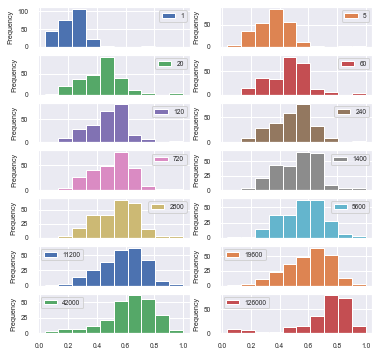

In [57]:
def compute_vol_corr_df(input_df, increments_list):
    corr_series_list = []
    squared_returns = all_returns_df.pow(2)
    for increment in increments_list:
        df = squared_returns.groupby(squared_returns.index // increment).sum().pow(1./2)
        corr_matrix = df.corr()
        upper_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        corr_series = corr_matrix.where(upper_mask).stack()
        corr_series.rename(increment, inplace=True)
        corr_series_list.append(corr_series)
    return pd.concat(corr_series_list, axis=1)

increments_list = [1, 5, 20, 60, 120, 240, 720, 1400, 1400 * 2, 1400 * 4, 1400 * 8, 1400 * 14, 1400 * 30, 1400 * 30 * 3]
sns.set_context('paper')
# sns.set(font_scale=0.1)
sns.set(rc={'figure.figsize':(6, 6)}, font_scale=0.6) 

df = compute_vol_corr_df(all_returns_df, increments_list)

info_string_list = [f"{increment} minute(s)" for increment in increments_list]

ax = df.plot.hist(subplots=True, legend=True, layout=(7,2))
figure_name = 'pairwise_vol_corr_hist_for_different_lookbacks.png'
figure_path = os.path.join(figures_path_base, figure_name)
ax[0][0].figure.savefig(figure_path, bbox_inches='tight', dpi=300)

In [42]:
df.mean()

1         0.228614
5         0.357137
20        0.427381
60        0.463473
120       0.480588
240       0.492121
720       0.511020
1400      0.524907
2800      0.541384
5600      0.559427
11200     0.578740
19600     0.601719
42000     0.626867
126000    0.714073
252000    0.816880
dtype: float64

In [38]:
increment = 1440
squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(squared_returns.index // increment).sum().pow(1./2)
volatilities = np.log(volatilities)

In [39]:
volatilities

,bnbbtc,adabtc,ethbtc,batbtc,btcusdc,btcusdt,neobtc,btctusd,etcbtc,ltcbtc,...,xmrbtc,zecbtc,qtumbtc,dcrbtc,xlmbtc,iotabtc,manabtc,dashbtc,zrxbtc,repbtc
0,-3.646080,-3.490317,-4.263519,-3.167749,-4.102373,-4.205471,-3.756042,-4.137266,-3.675125,-3.509442,...,-3.473442,-3.817452,-3.038712,-3.432752,-3.524593,-3.421993,-3.549608,-3.583785,-4.006582,-3.601219
1,-3.135412,-3.673140,-4.397775,-3.163411,-4.060437,-4.090067,-3.646452,-4.089080,-3.912515,-3.820049,...,-3.607421,-3.457632,-2.553002,-3.836356,-3.760822,-3.342895,-3.724117,-3.766026,-3.883003,-3.569582
2,-3.117921,-3.039837,-3.707069,-2.960022,-3.318531,-3.409968,-3.397183,-3.232445,-3.418485,-3.109647,...,-3.568241,-3.522155,-3.114819,-3.495093,-3.351408,-3.167307,-3.385903,-3.702427,-3.399374,-3.371649
3,-3.186163,-3.260166,-3.862285,-2.867723,-3.340964,-3.449836,-3.624266,-3.351457,-3.414148,-3.161514,...,-3.412460,-3.708632,-3.185759,-3.539669,-3.481192,-3.257685,-3.298653,-3.025143,-3.486409,-3.441019
4,-3.404492,-3.633308,-4.202068,-3.174913,-3.656917,-3.674849,-3.887739,-3.619831,-3.732302,-3.725101,...,-3.800859,-3.856082,-3.728819,-3.804197,-3.619746,-3.544403,-3.066144,-3.543753,-4.000332,-3.785197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,-4.293401,-3.711330,-4.159584,-3.911395,-3.387212,-3.381742,-3.689468,-3.612781,-3.689283,-3.862494,...,-2.962028,-3.240649,-3.683686,-3.018884,-3.637944,-3.785280,-3.622679,-3.602287,-2.252649,-3.912437
1092,-4.366544,-3.652357,-4.210524,-4.140776,-3.409835,-3.413336,-4.042713,-3.690754,-3.939284,-3.980981,...,-3.181339,-3.226242,-4.113919,-3.044028,-3.742751,-3.965549,-3.742037,-3.959617,-2.329668,-3.407090
1093,-3.809188,-3.845991,-4.024196,-3.915296,-3.378317,-3.369028,-3.836040,-3.486279,-3.732145,-3.576779,...,-3.143918,-3.446120,-3.873072,-3.431734,-3.613387,-4.016192,-3.652105,-3.629712,-2.799976,-3.514793
1094,-4.255195,-3.842183,-4.296385,-3.917886,-3.584833,-3.583122,-3.897528,-3.789560,-3.628653,-3.755894,...,-2.945687,-3.278320,-3.945155,-2.455022,-3.710868,-3.855663,-3.410907,-3.459158,-3.349358,-3.106467


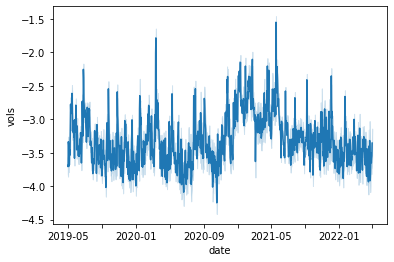

In [37]:
increment = 1440
squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(squared_returns.index // increment).sum().pow(1./2)
volatilities = np.log(volatilities)
date = volatilities.index.to_series().apply(lambda x: dt.datetime(2019, 5, 1) + dt.timedelta(days=x))
daily_volatilities = pd.concat([volatilities, date], axis=1)
daily_volatilities.rename(columns={0: 'date'}, inplace=True)
molten = daily_volatilities.melt('date', var_name='assets', value_name='vols')
plt = sns.lineplot(data=molten, x='date', y='vols')
# plt.xaxis.set_xticklabels(plt.xaxis.get_xticklabels(), rotation=30)
# plt.xticks(rotation=30)
for i, label in enumerate(plt.xaxis.get_ticklabels()):
    if i % 2 != 0:
        label.set_visible(False)
        
figure_name = 'vol_corr_hist.png'
figure_path = os.path.join(figures_path_base, figure_name)
ax[0][0].figure.savefig(figure_path, bbox_inches='tight', dpi=300)

In [ ]:
# optional if i want to winsorise
# df2 = df.clip(lower=df.quantile(0.01), upper=df.quantile(0.99), axis=1)
# df2.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])

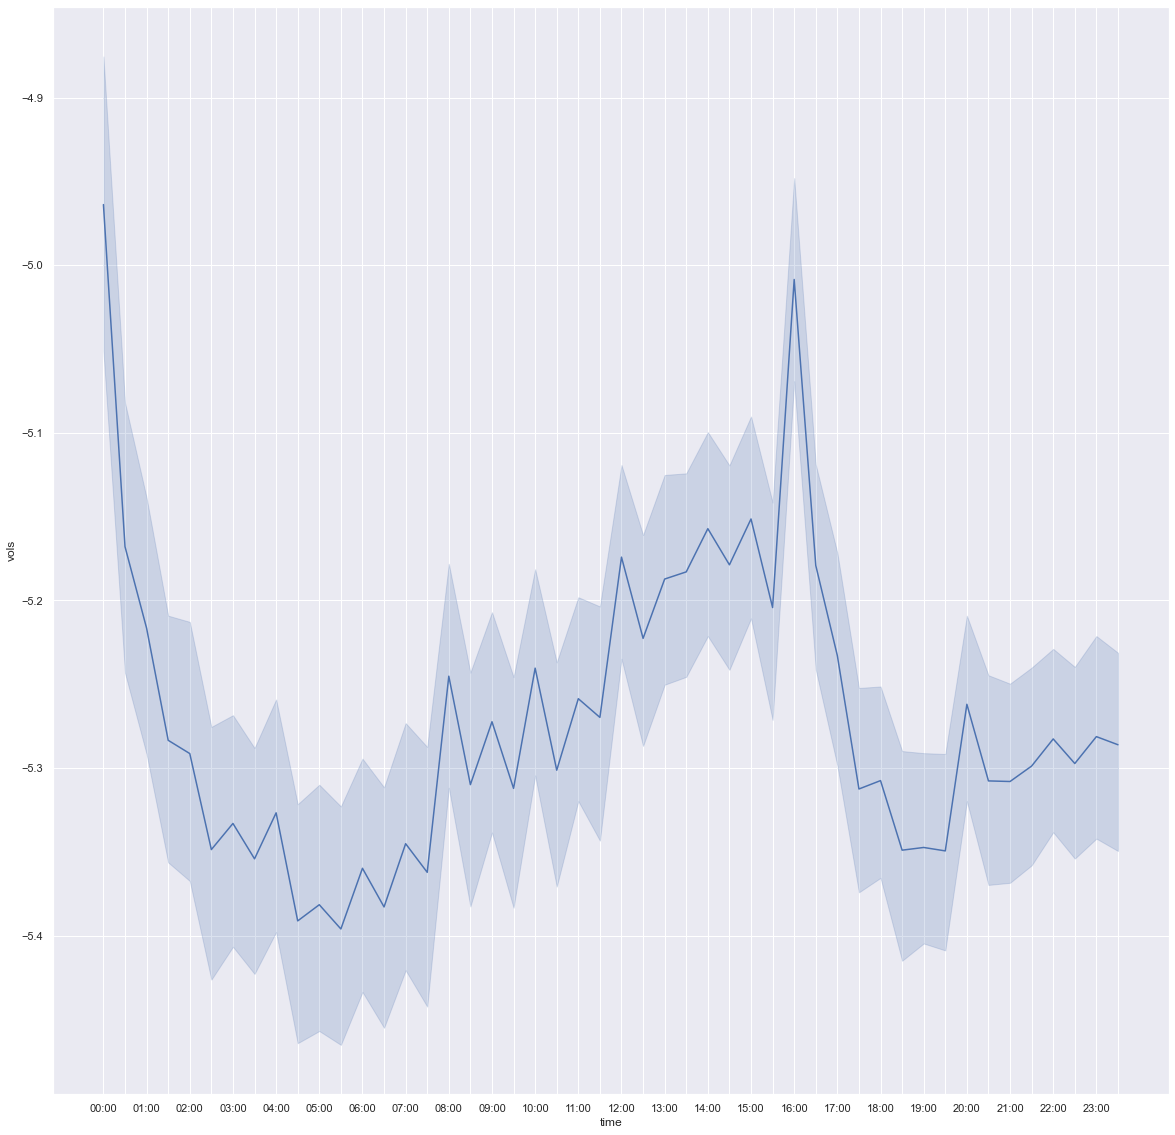

In [43]:
increment = 30
ticks = 1440 / increment

squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(squared_returns.index // increment).sum().pow(1./2)
diurnal_volatilities = volatilities.groupby(volatilities.index % ticks).mean()
diurnal_volatilities = np.log(diurnal_volatilities)
time_of_day = (diurnal_volatilities.index.to_series() * increment * 60).astype(int).apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%H:%M'))
timed_diurnal_volatilities = pd.concat([diurnal_volatilities, time_of_day], axis=1)
timed_diurnal_volatilities.rename(columns={0: 'time'}, inplace=True)
molten = timed_diurnal_volatilities.melt('time', var_name='assets', value_name='vols')
plt = sns.lineplot(data=molten, x='time', y='vols')
if increment < 60:
    for i, label in enumerate(plt.xaxis.get_ticklabels()):
        if i % int(60 / increment) != 0:
            label.set_visible(False)